In [1]:
# Prerequisites 

from pathlib import Path
import pandas as pd
from ordered_set import OrderedSet
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import json
from yaml.loader import SafeLoader
import cobra
from cobra.io import load_model
from cobra import Model, Reaction, Metabolite
from pathlib import Path
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model, load_model, load_yaml_model, save_yaml_model
import logging
from cobra.sampling import sample
from cobra.medium import minimal_medium
import ast
import sys
import numpy as np

# load model

In [2]:
eg_path = Path("/Users/philine/Downloads/yeast-GEM-8.6.2/model")
yml_path = eg_path / "yeast-GEM.yml"
model = load_yaml_model(str(yml_path.resolve()))
model

Restricted license - for non-production use only - expires 2024-10-28


Name,None
Memory address,7f935a6bb310
Number of metabolites,2744
Number of reactions,4063
Number of genes,1160
Number of groups,0
Objective expression,1.0*r_2111 - 1.0*r_2111_reverse_58b69
Compartments,"cell envelope, cytoplasm, extracellular, mitochondrion, nucleus, peroxisome, endoplasmic reticulum, Golgi, lipid particle, vacuole, endoplasmic reticulum membrane, vacuolar membrane, Golgi membrane, mitochondrial membrane"


# load csvs

In [3]:
# read csv contaning pathway with highest objective value
max_pathway = pd.read_csv('max_pathway.csv')
max_pathway['INTERMEDIATE NAMES'] = [ast.literal_eval(i) for i in max_pathway['INTERMEDIATE NAMES']]
max_pathway['INTERMEDIATES KEGG'] = [ast.literal_eval(i) for i in max_pathway['INTERMEDIATES KEGG']]
max_pathway

,LENGTH,INTERMEDIATES KEGG,INTERMEDIATE NAMES,solution
0,6,"[C06793, C20609, C00288, C00222, C10020, C0460...","[Vinyl chloride, 2-Chloroacrylate, H2CO3, 3-Ox...",9.379374


## select dataset to use

In [4]:
df = max_pathway

# prep model

In [5]:
# create function that prepares model (set objective function, solver and remove carbon source)
def prep_model(model):
    
    model.solver = 'glpk'
    model.objective = 'r_4041'
    
    medium = model.medium
    medium['r_1714'] = 0.0
    model.medium = medium
    
    return model

model = prep_model(model)

In [37]:
#get csv containing s id and kegg id
sid_kegg = pd.read_csv('map_sid_kegg.csv')


# create dictionary of sid_kegg data frame
sk_dict = dict(zip(sid_kegg['S ID'], sid_kegg['KEGG ID']))

# get plastics

In [7]:
# create function that gets all plastics

def get_plastics(df):
    
    csv_pathways = [i for i in df['INTERMEDIATES KEGG']]

    get_plastic = set()

    for i in csv_pathways:
        if i[0] not in get_plastic:
            get_plastic.add(i[0])

    plastics = list(get_plastic)
    return plastics

In [8]:
# get all plastics from dataset
plastics = get_plastics(df)
plastics

['C06793']

In [9]:
# create plastic metabolites

## Propene

C11505_e = Metabolite(
    'C11505_e',
    formula = 'C3H6',
    name = 'Propene',
    compartment = 'e')

C11505_c = Metabolite(
    'C11505_c',
    formula = 'C3H6',
    name = 'Propene',
    compartment = 'c')


## Vinyl Chloride

C06793_e = Metabolite(
    'C06793_e',
    formula = 'C2H3Cl',
    name = 'Vinyl Chloride',
    compartment = 'e')

C06793_c = Metabolite(
    'C06793_c',
    formula = 'C2H3Cl',
    name = 'Vinyl Chloride',
    compartment = 'c')


## Ethylene

C06547_e = Metabolite(
    'C06547_e',
    formula = 'C2H4',
    name = 'Ethylene',
    compartment = 'e')

C06547_c = Metabolite(
    'C06547_c',
    formula = 'C2H4',
    name = 'Ethylene',
    compartment = 'c')


## Styrene

C07083_e = Metabolite(
    'C07083_e',
    formula = 'C8H8',
    name = 'Styrene',
    compartment = 'e')

C07083_c = Metabolite(
    'C07083_c',
    formula = 'C8H8',
    name = 'Styrene',
    compartment = 'c')


## Terephthalate 

C06337_e = Metabolite(
    'C06337_e',
    formula = 'C8H6O4',
    name = 'Terephthalate',
    compartment = 'e')

C06337_c = Metabolite(
    'C06337_c',
    formula = 'C8H6O4',
    name = 'Terephthalate',
    compartment = 'c')

In [10]:
# create plastic dictionary an dadd metabolits
plastic_dict = {}

plastic_dict['C11505_c'] = C11505_c
plastic_dict['C06793_c'] = C06793_c
plastic_dict['C06547_c'] = C06547_c
plastic_dict['C07083_c'] = C07083_c
plastic_dict['C06337_c'] = C06337_c

plastic_dict['C11505_e'] = C11505_e
plastic_dict['C06793_e'] = C06793_e
plastic_dict['C06547_e'] = C06547_e
plastic_dict['C07083_e'] = C07083_e
plastic_dict['C06337_e'] = C06337_e

In [11]:
# add plastic metabolites to dictionary

sk_dict['C11505_c'] = C11505_c
sk_dict['C06793_c'] = C06793_c
sk_dict['C06547_c'] = C06547_c
sk_dict['C07083_c'] = C07083_c
sk_dict['C06337_c'] = C06337_c

sk_dict['C11505_e'] = C11505_e
sk_dict['C06793_e'] = C06793_e
sk_dict['C06547_e'] = C06547_e
sk_dict['C07083_e'] = C07083_e
sk_dict['C06337_e'] = C06337_e

# run fba

In [12]:
# create algorithm that runs fba and predicts growing pathways

def fba(df, model, plastics):
    
    # get pathways from data frame
    pathways = [i for i in df['INTERMEDIATES KEGG']]
    
    
    
    # change name of plastics so that it matches version in dict
    for i in pathways:
        for e, compound in enumerate(i):
            if compound in plastics:
                i[e] = compound + '_c'
                
    
    
    # get list of cytosolic plastics (for later analysis)
    plastics_c = plastics.copy()

    for e, compound in enumerate(plastics_c):
        plastics_c[e] = compound + '_c'
     
    
            
    # get external plastics        
    e_plastics = plastics.copy()
    
    for i, plastic in enumerate(plastics):
        e_plastics[i] = plastic + '_e'
   
     
    
    # get list of products    
    products = [i[-1] for i in pathways]
    products = list(set(products))
    
    
    
    # get external products
    e_products = products.copy()
    
    for i, prod in enumerate(products):
        e_products[i] = prod + '_e'

    
    
    # get name of compounds that are not present in model
    get_compound = set()

    for pathway in pathways:
        for compound in pathway:
            if compound not in plastic_dict and compound not in sk_dict.values() and compound not in get_compound:
                get_compound.add(compound)

    get_compound = list(get_compound)
    
    

    # create names for missing metabolites
    compound_name = []

    for i, compound in enumerate(get_compound):
        comp = f"Metabolite_{i}"
        compound_name.append(comp)

        
    
    # take list of missing compounds, create metabolites and add to dictionaries
    metabolites = []
    met_dict = {}

    for compound in get_compound:
        new_met = Metabolite(compound, compartment='c')
        metabolites.append(new_met)
        sk_dict[compound] = new_met
        met_dict[compound] = new_met
        
    
    
    # add external plastics to list of pathways
    ext = []
    
    for pathway in pathways:
        if pathway[0] in plastics_c:
            index = plastics_c.index(pathway[0])
            ext.append(e_plastics[index])
        
        

    # add external products (weren't in list before) and add to model
    ext_p = []

    for i in e_products:
        new_prod = Metabolite(i, compartment='e')
        ext_p.append(new_prod)
        sk_dict[i] = new_prod

    model.add_metabolites(ext_p)
    
    
    # add external plastics to list of pathways
    ext2 = []
    
    for pathway in pathways:
        if pathway[-1] in products:
            index = products.index(pathway[-1])
            ext2.append(e_products[index])

    
            
    # add external lists to pathways     
    for i, item in enumerate(ext):
        pathways[i].insert(0, item)
    
    for j, item in enumerate(ext2):
        pathways[j].append(item)

        
        
    # transform coompounds in pathways list to metabolites
    for i in pathways:
        for j, item in enumerate(i):
            
            found = False
            

            if item in sk_dict:
                i[j] = sk_dict[item]
                found = True

            if not found and item in met_dict:
                i[j] = sk_dict[item]
                found = True

            if not found and item in sk_dict.values():
                temp = [key for key, value in sk_dict.items() if value == item]
                if temp:
                    temp2 = temp[0]
                    met = model.metabolites.get_by_id(temp2)
                    i[j] = met
                    found = True

            if not found:
                i[j] = item


    
    # separate list of pathways into twos (metabolite_1 --> metabolite 2)
                                        # (metabolite_2 --> metabolite_3)
                                        #  etc. 
    separated_pathways = []

    for i in pathways:
        pathway_pairs = []
        for j in range(len(i)-1):
            pair = [i[j], i[j+1]]
            pathway_pairs.append(pair)
        separated_pathways.append(pathway_pairs)
        
    
    
    # get number of reactions in pathway
    react_num = 0
    for i in separated_pathways:
        react_num += len(i)
        
        
     
    # create empty reactions using number above
    reactions = []

    for i in range(react_num):
        reaction = f"Reaction_{i}"

        new_reaction = Reaction(reaction)

        reactions.append(new_reaction)
        
        
        
    # create output list    
    grows = []
   

    
    # add metabolites to reactions and reaction to model
    for m, e in enumerate(separated_pathways):
        
        reactions_added = []
        
        for i, item in enumerate(e):
            
            # Add reaction to the model
            model.add_reactions([reactions[i]])
            
            # Add metabolites to reaction
            reactions[i].add_metabolites({
                    item[0]: -1.0,
                    item[1]: 1.0
                    })


            # for first and last reactions, create exchange reactions
            if i == 0 or i == len(e)-1:
                reactions[i].lower_bound = -10.0
                reactions[i].upper_bound = 1000.0
                
                
            # for all others, create normal (oneway) reactions
            else:
                reactions[i].lower_bound = 0.0
                reactions[i].upper_bound = 1000.0
 

            reactions_added.append(reactions[i])
            
            
            
        # run FBA on model    
        solution = model.optimize()
        
        
        
        # if cell can grow, store results
        if solution.status == 'optimal' and solution.objective_value > 0.000:

            grows.append(solution)

            # remove all reactions and metabolites added within the loop
            model.remove_reactions(reactions_added)

            reactions = [reaction for reaction in reactions if reaction not in reactions_added]

            del reactions_added[:]

            

        else:
            
            # remove all reactions and metabolites added within the loop
            model.remove_reactions(reactions_added)

            reactions = [reaction for reaction in reactions if reaction not in reactions_added]

            del reactions_added[:]
            
    
    
    return (solution)

# results

In [13]:
max_pathway = fba(df, model, plastics)
max_pathway

,fluxes,reduced_costs
r_0001,0.000000,3.528139e-21
r_0002,0.000000,-1.734723e-18
r_0003,0.000000,-1.002467e-17
r_0004,0.000000,0.000000e+00
r_0005,7.020602,1.387779e-17
...,...,...
Reaction_3,1000.000000,1.111208e-03
Reaction_4,0.000000,-7.778457e-03
Reaction_5,0.000000,0.000000e+00
Reaction_6,0.000000,0.000000e+00


## top 20

In [14]:
import pandas as pd

N = 20  # The number of top reactions you want to display

# Create a DataFrame from the FBA results
fluxes = pd.Series(max_pathway.fluxes)

# Get the top N reactions with the highest absolute flux values
top_fluxes = fluxes.abs().nlargest(N)

In [15]:
top_fluxes

r_0438        1000.000000
r_1667        1000.000000
r_2100        1000.000000
Reaction_3    1000.000000
r_1277        1000.000000
r_1110         839.046619
r_2096         780.528853
r_1245         742.941701
r_0226         715.939839
r_0165         600.967528
r_1632         600.967528
r_1763         600.967528
r_4575         600.967528
r_1761         594.599253
r_1762         594.599253
r_1696         588.315894
r_0439         500.000000
r_0658         427.299662
r_4574         399.030690
r_1672         374.896242
Name: fluxes, dtype: float64

In [16]:
len(top_fluxes)

20

# non-zero flux distribution

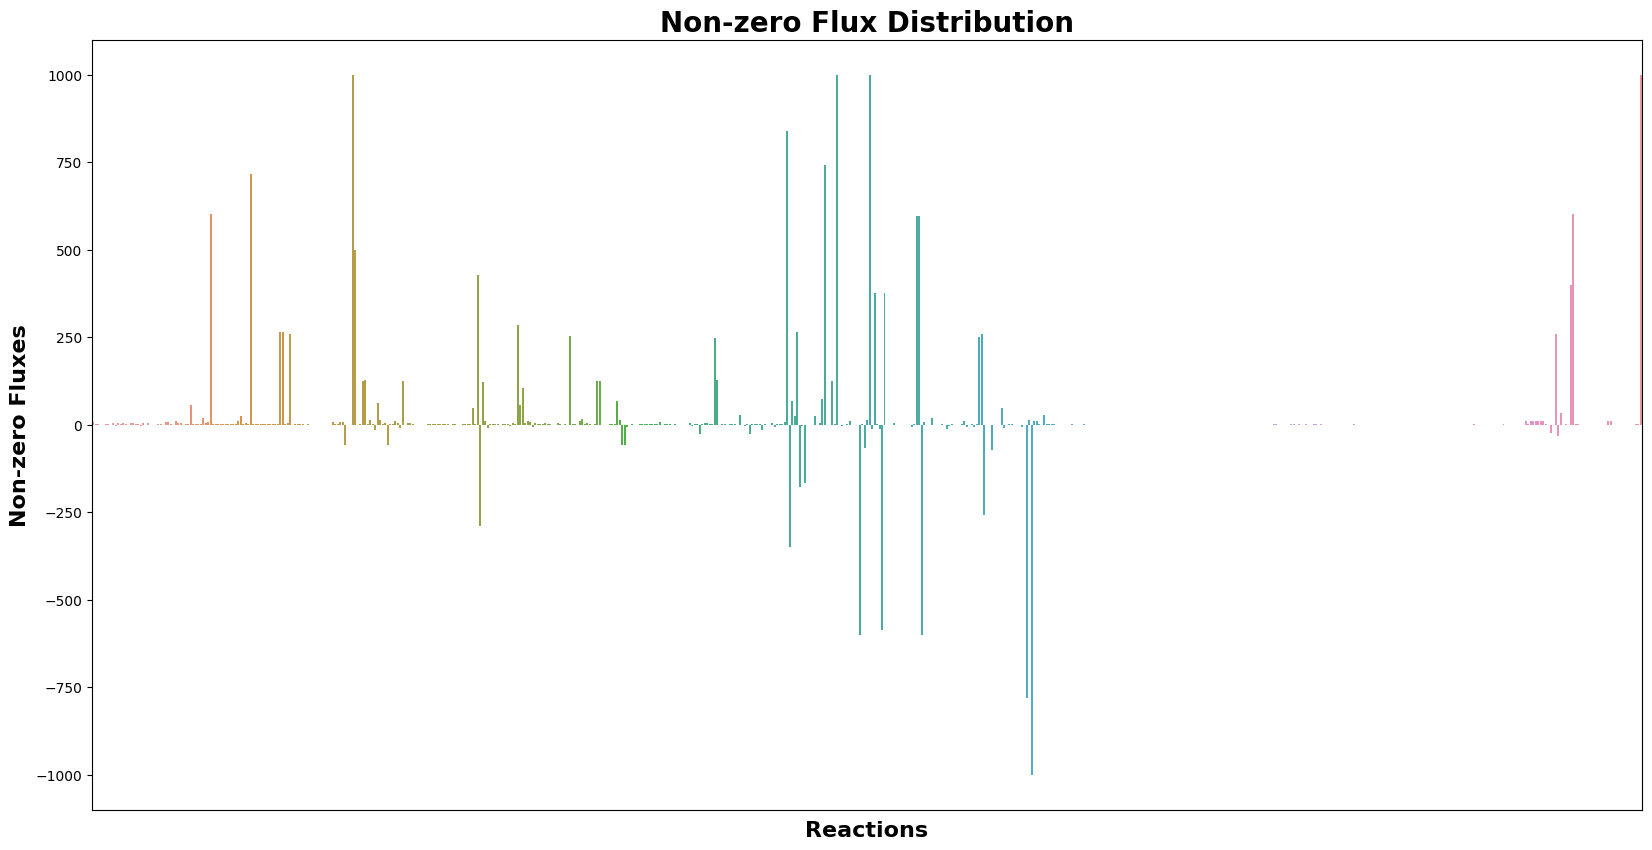

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a cobrapy model called 'model'
#solution = model.optimize()

# Convert the flux distribution into a pandas DataFrame
fluxes = pd.Series(max_pathway.fluxes)
fluxes_df = fluxes.reset_index().rename(columns={'index': 'Reaction', 0: 'fluxes'})

# Filter the DataFrame to include only non-zero fluxes
non_zero_fluxes_df = fluxes_df[fluxes_df['fluxes'] != 0]

# Create a bar chart of the non-zero fluxes
plt.figure(figsize=(20, 10))
sns.barplot(x='Reaction', y='fluxes', data=non_zero_fluxes_df)
plt.xticks([])
plt.xlabel('Reactions', fontsize=16, fontweight='bold') # Increase the x-label font size
plt.ylabel('Non-zero Fluxes', fontsize=16, fontweight='bold') # Increase the y-label font size
plt.title('Non-zero Flux Distribution', fontsize=20, fontweight='bold') # Increase the title font size
plt.show()


# get subsytsem

In [18]:
# loading yeast metabolic model

model_path = '/Users/philine/Downloads/yeast-GEM-8.6.2/model/yeast-GEM.yml'

with open(model_path) as file:
    data = yaml.load(file, Loader=yaml.FullLoader)

In [19]:
non_zero_fluxes_df

,Reaction,fluxes
4,r_0005,7.020602e+00
5,r_0006,2.345703e+00
6,r_0007,7.143068e-01
9,r_0014,9.379374e-03
10,r_0015,9.379374e-03
...,...,...
4039,r_4686,3.969748e-30
4053,r_4701,-2.520175e+00
4054,r_4702,1.901039e+00
4055,r_4703,1.901039e+00


In [20]:
# access reactions section of model
reactions = data[2]

In [21]:
# get all subsystems found in model
subsystems = []
for i in reactions[1]:
    #print(i[0])
    for j in i:
        #print(j[0])
        if j[0] == 'subsystem':
            if j[1] not in subsystems:
                subsystems.append(j[1])

                
subsystems

[['Pyruvate metabolism'],
 ['Butanoate metabolism'],
 ['Starch and sucrose metabolism'],
 ['Histidine metabolism'],
 ['Alanine, aspartate and glutamate metabolism'],
 ['Cysteine and methionine metabolism'],
 ['Riboflavin metabolism'],
 ['Valine, leucine and isoleucine metabolism'],
 ['Folate biosynthesis'],
 ['Lysine metabolism'],
 ['Pantothenate and coa biosynthesis'],
 ['Phenylalanine, tyrosine and tryptophan biosynthesis'],
 ['Ubiquinone and other terpenoid-quinone biosynthesis'],
 ['Propanoate metabolism'],
 ['Sulfur metabolism'],
 ['Purine metabolism'],
 ['Sphingolipid metabolism'],
 ['Tryptophan metabolism'],
 ['Fatty acid degradation'],
 ['Complex alcohol metabolism'],
 ['Vitamin b6 metabolism'],
 ['Inositol phosphate metabolism'],
 ['Phosphatidylinositol signaling system'],
 ['Nicotinate and nicotinamide metabolism'],
 ['One carbon pool by folate'],
 ['Porphyrin and chlorophyll metabolism'],
 ['Fructose and mannose metabolism'],
 ['Pentose phosphate pathway'],
 ['Biotin metabol

In [22]:
# Create a dictionary to store the mapping of reaction IDs to subsystems
reaction_subsystem_map = {}
for a in reactions[1]:
    reaction_id = None
    subsystem = None
    for b in a:
        if b[0] == 'subsystem':
            subsystem = b[1]
        elif b[0] == 'id':  
            reaction_id = b[1]

    if reaction_id is not None and subsystem is not None:
        reaction_subsystem_map[reaction_id] = subsystem

        
# Create a new column 'Subsystem' in non_zero_fluxes_df
non_zero_fluxes_df['Subsystem'] = non_zero_fluxes_df['Reaction'].map(reaction_subsystem_map)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [23]:
# drop none values
non_zero_fluxes_df = non_zero_fluxes_df.dropna()
non_zero_fluxes_df

,Reaction,fluxes,Subsystem
4,r_0005,7.020602e+00,[Starch and sucrose metabolism]
5,r_0006,2.345703e+00,[Starch and sucrose metabolism]
6,r_0007,7.143068e-01,[Histidine metabolism]
9,r_0014,9.379374e-03,[Riboflavin metabolism]
10,r_0015,9.379374e-03,[Riboflavin metabolism]
...,...,...,...
4031,r_4678,-3.969748e-30,[Fatty acid ester pathway]
4039,r_4686,3.969748e-30,"[Transport [c, p]]"
4053,r_4701,-2.520175e+00,[Sulfur metabolism]
4054,r_4702,1.901039e+00,[Sulfur metabolism]


# group and get agg value

In [24]:
non_zero_fluxes_df['Subsystem'] = non_zero_fluxes_df['Subsystem'].astype(str)
non_zero_fluxes_df['Subsystem'] = [i.replace('[','').replace(']','').replace("'", '') for i in non_zero_fluxes_df['Subsystem']]
non_zero_fluxes_df['count'] = non_zero_fluxes_df.groupby('Subsystem')['Subsystem'].transform('count')
non_zero_fluxes_df

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

,Reaction,fluxes,Subsystem,count
4,r_0005,7.020602e+00,Starch and sucrose metabolism,5
5,r_0006,2.345703e+00,Starch and sucrose metabolism,5
6,r_0007,7.143068e-01,Histidine metabolism,9
9,r_0014,9.379374e-03,Riboflavin metabolism,9
10,r_0015,9.379374e-03,Riboflavin metabolism,9
...,...,...,...,...
4031,r_4678,-3.969748e-30,Fatty acid ester pathway,2
4039,r_4686,3.969748e-30,"Transport c, p",5
4053,r_4701,-2.520175e+00,Sulfur metabolism,8
4054,r_4702,1.901039e+00,Sulfur metabolism,8


## count

In [25]:
# count number of subsystem involvation
category_count = non_zero_fluxes_df.groupby('Subsystem').size().reset_index(name='Count')
category_count

,Subsystem,Count
0,"Alanine, aspartate and glutamate metabolism",10
1,Alternate carbon metabolism,1
2,Amino sugar and nucleotide sugar metabolism,1
3,Arginine and proline metabolism,3
4,Arginine biosynthesis,7
...,...,...
63,"Transport erm, vm",4
64,Tryptophan metabolism,6
65,Tyrosine metabolism,1
66,"Valine, leucine and isoleucine metabolism",17


# absolute top 20

In [26]:
# get 20 absolute highest fluxes
abs_20 = non_zero_fluxes_df.copy()
abs_20

,Reaction,fluxes,Subsystem,count
4,r_0005,7.020602e+00,Starch and sucrose metabolism,5
5,r_0006,2.345703e+00,Starch and sucrose metabolism,5
6,r_0007,7.143068e-01,Histidine metabolism,9
9,r_0014,9.379374e-03,Riboflavin metabolism,9
10,r_0015,9.379374e-03,Riboflavin metabolism,9
...,...,...,...,...
4031,r_4678,-3.969748e-30,Fatty acid ester pathway,2
4039,r_4686,3.969748e-30,"Transport c, p",5
4053,r_4701,-2.520175e+00,Sulfur metabolism,8
4054,r_4702,1.901039e+00,Sulfur metabolism,8


In [38]:
# get names of reactions

name_dict = {}

for i in data[2][1]:
    if i[0][0] == 'id':
        name_dict[i[0][1]] = i[1][1]        

In [28]:
# add absolute fluxes to data frame
abs_20['abs_fluxes'] = abs_20['fluxes'].apply(abs)
top_abs = abs_20.sort_values('abs_fluxes', ascending=False).head(20)
top_abs

,Reaction,fluxes,Subsystem,count,abs_fluxes
1493,r_2100,-1000.000000,Exchange reaction,24,1000.000000
1137,r_1667,1000.000000,Nitrogen metabolism,2,1000.000000
334,r_0438,1000.000000,Oxidative phosphorylation,5,1000.000000
1003,r_1277,1000.000000,"Transport c, e",23,1000.000000
860,r_1110,839.046619,"Transport c, m",41,839.046619
1489,r_2096,-780.528853,"Transport c, m",41,780.528853
974,r_1245,742.941701,"Transport c, m",41,742.941701
202,r_0226,715.939839,Oxidative phosphorylation,5,715.939839
1223,r_1763,-600.967528,"Transport c, m",41,600.967528
1108,r_1632,-600.967528,"Transport c, m",41,600.967528


In [29]:
# add reaction name to df
top_abs['Name'] = ''

for i in top_abs['Reaction']:
    if i in name_dict:
        # Get the index of the row with the current reaction
        index = top_abs[top_abs['Reaction'] == i].index[0]
        
        # Append the new name to the current value in the 'Name' column
        top_abs.loc[index, 'Name'] = top_abs.loc[index, 'Name'] + name_dict[i]
        
top_abs['Name'] = top_abs['Name'].str.capitalize()
top_abs

,Reaction,fluxes,Subsystem,count,abs_fluxes,Name
1493,r_2100,-1000.000000,Exchange reaction,24,1000.000000,Water exchange
1137,r_1667,1000.000000,Nitrogen metabolism,2,1000.000000,Bicarbonate formation
334,r_0438,1000.000000,Oxidative phosphorylation,5,1000.000000,Ferrocytochrome-c:oxygen oxidoreductase
1003,r_1277,1000.000000,"Transport c, e",23,1000.000000,Water diffusion
860,r_1110,839.046619,"Transport c, m",41,839.046619,Adp/atp transporter
1489,r_2096,-780.528853,"Transport c, m",41,780.528853,Water diffusion
974,r_1245,742.941701,"Transport c, m",41,742.941701,Phosphate transport
202,r_0226,715.939839,Oxidative phosphorylation,5,715.939839,Atp synthase
1223,r_1763,-600.967528,"Transport c, m",41,600.967528,"Ethanol transport, mitochondrial"
1108,r_1632,-600.967528,"Transport c, m",41,600.967528,Acetaldehyde transport


In [31]:
# Create a dictionary from the 'Reaction' and 'Subsystem' columns
reaction_subsystem_dict = dict(zip(non_zero_fluxes_df['Reaction'], non_zero_fluxes_df['Subsystem']))

# Filter the dictionary based on the top_fluxes.index
flux_dict = {key: value for key, value in reaction_subsystem_dict.items() if key in top_fluxes.index}
flux_dict

{'r_0165': 'Glycolysis / gluconeogenesis',
 'r_0226': 'Oxidative phosphorylation',
 'r_0438': 'Oxidative phosphorylation',
 'r_0439': 'Oxidative phosphorylation',
 'r_0658': 'Citrate cycle (TCA cycle)',
 'r_1110': 'Transport c, m',
 'r_1245': 'Transport c, m',
 'r_1277': 'Transport c, e',
 'r_1632': 'Transport c, m',
 'r_1667': 'Nitrogen metabolism',
 'r_1672': 'Exchange reaction',
 'r_1696': 'Transport c, m',
 'r_1761': 'Exchange reaction',
 'r_1762': 'Transport c, e',
 'r_1763': 'Transport c, m',
 'r_2096': 'Transport c, m',
 'r_2100': 'Exchange reaction',
 'r_4574': 'Beta-alanine metabolism',
 'r_4575': 'Alternate carbon metabolism'}

In [32]:
# get number of appearance of most common subsystem
for i in category_count['Subsystem']:
    if i == 'Glycerophospholipid metabolism':
        print(category_count.loc[category_count['Subsystem'] == i])

                         Subsystem  Count
20  Glycerophospholipid metabolism     46


# graphs

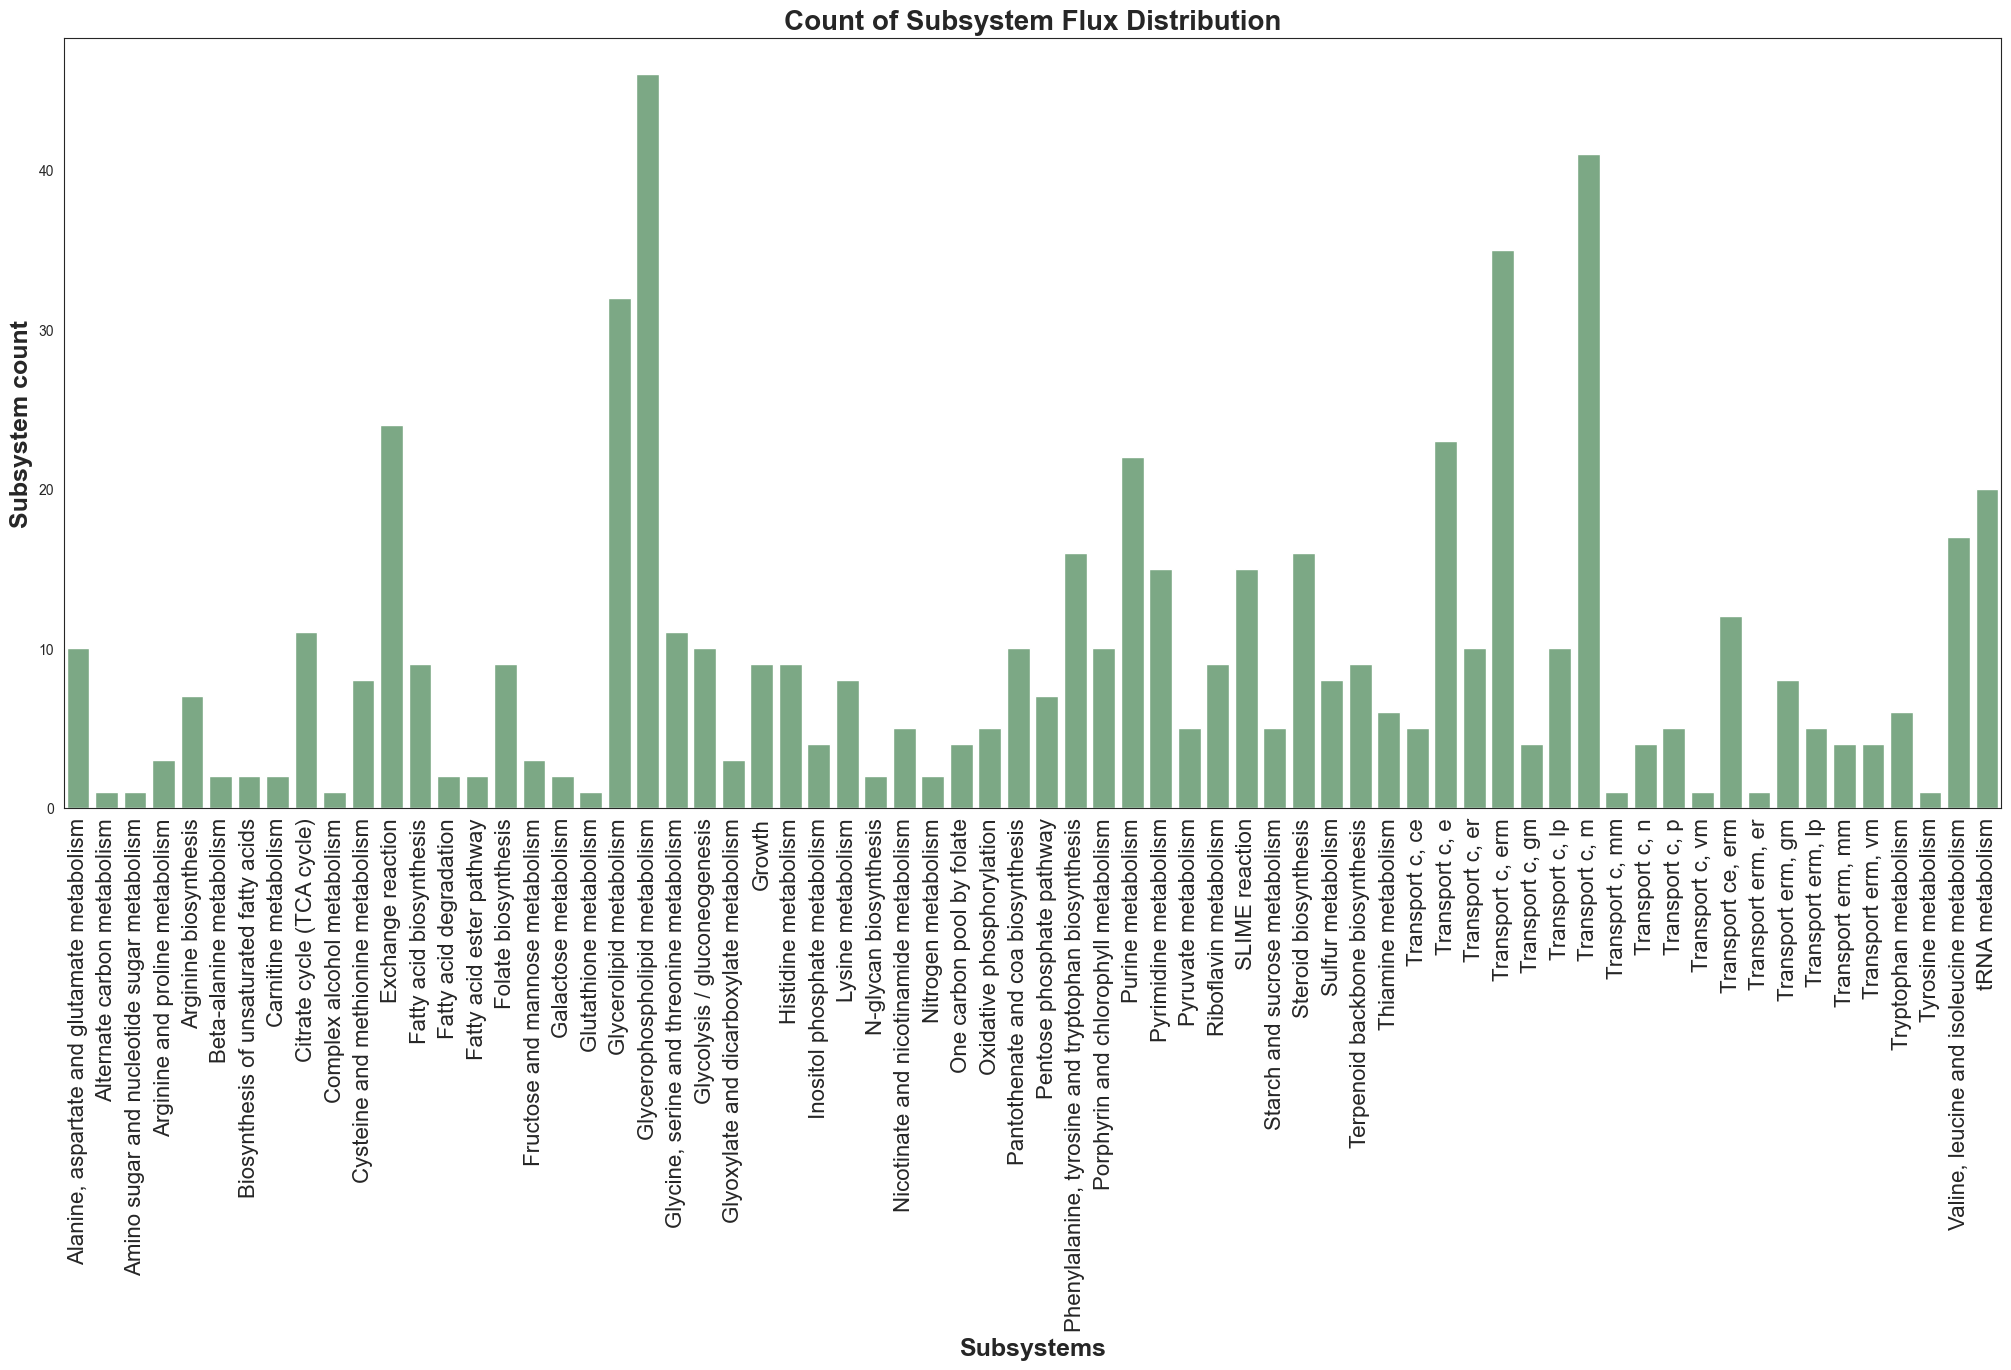

In [33]:
# plot subsystems vs number of occurrence
green_ombre_palette = sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=0.6, n_colors=50)

# Create a color list using the green ombre palette
color_list = [green_ombre_palette[int(i)] for i in np.linspace(0, 49, 1)]


plt.figure(figsize=(25, 10))
sns.set_style("white")
sns.barplot(x='Subsystem', y='Count', data=category_count, palette = color_list)
plt.xticks(rotation=90 , fontsize=16)
plt.xlabel('Subsystems', fontsize=18, fontweight = 'bold')
plt.ylabel('Subsystem count', fontsize=18, fontweight = 'bold')
plt.title('Count of Subsystem Flux Distribution', fontsize=20, fontweight = 'bold')
plt.show()

In [34]:
# highest absolute reactions
top_abs

,Reaction,fluxes,Subsystem,count,abs_fluxes,Name
1493,r_2100,-1000.000000,Exchange reaction,24,1000.000000,Water exchange
1137,r_1667,1000.000000,Nitrogen metabolism,2,1000.000000,Bicarbonate formation
334,r_0438,1000.000000,Oxidative phosphorylation,5,1000.000000,Ferrocytochrome-c:oxygen oxidoreductase
1003,r_1277,1000.000000,"Transport c, e",23,1000.000000,Water diffusion
860,r_1110,839.046619,"Transport c, m",41,839.046619,Adp/atp transporter
1489,r_2096,-780.528853,"Transport c, m",41,780.528853,Water diffusion
974,r_1245,742.941701,"Transport c, m",41,742.941701,Phosphate transport
202,r_0226,715.939839,Oxidative phosphorylation,5,715.939839,Atp synthase
1223,r_1763,-600.967528,"Transport c, m",41,600.967528,"Ethanol transport, mitochondrial"
1108,r_1632,-600.967528,"Transport c, m",41,600.967528,Acetaldehyde transport


In [35]:
print(top_abs['fluxes'])

1493   -1000.000000
1137    1000.000000
334     1000.000000
1003    1000.000000
860      839.046619
1489    -780.528853
974      742.941701
202      715.939839
1223    -600.967528
1108    -600.967528
143      600.967528
3933     600.967528
1221     594.599253
1222     594.599253
1163    -588.315894
335      500.000000
522      427.299662
3932     399.030690
1141     374.896242
1164     374.896242
Name: fluxes, dtype: float64


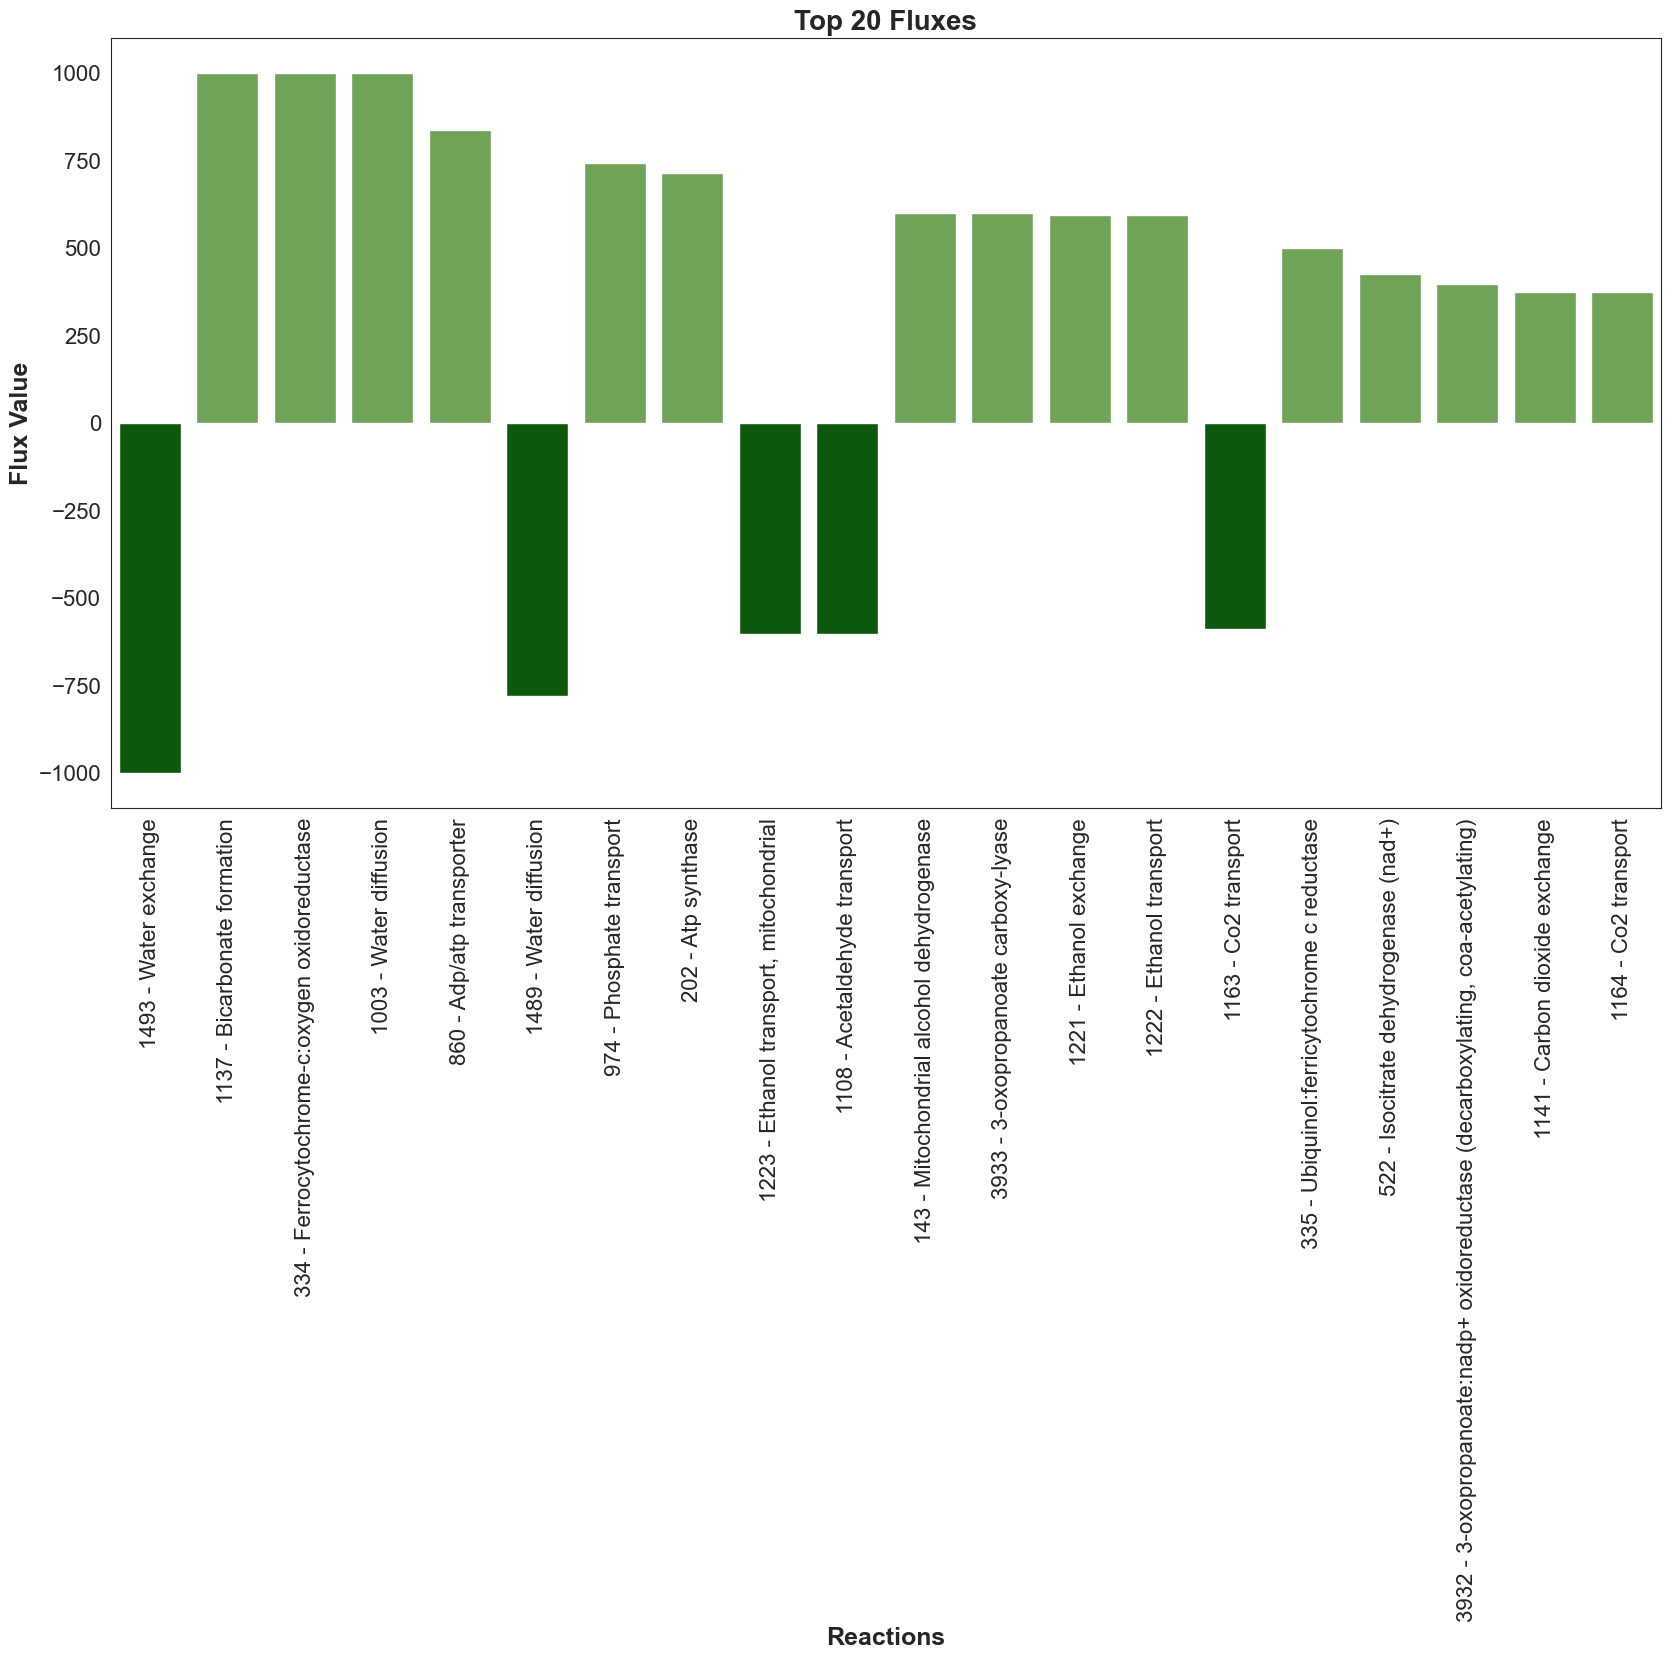

In [36]:
# plot 20 highest fluxes
top_abs['unique_label'] = top_abs.index.astype(str) + ' - ' + top_abs['Name']

# Create a color list based on the sign of the fluxes
color_list = ['#6AB04A' if x > 0 else 'darkgreen' for x in top_abs['fluxes']]

# Create the bar plot
plt.figure(figsize=(20, 10))
sns.barplot(x='unique_label', y='fluxes', data=top_abs, palette=color_list)
plt.xticks(rotation=90, fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Reactions', fontsize = 18, fontweight = 'bold')
plt.ylabel('Flux Value', fontsize = 18, fontweight = 'bold')
plt.title('Top 20 Fluxes', fontsize = 20, fontweight = 'bold')
plt.show()